In [60]:
#OBINNA AGBO# 
# Import necessary libraries
import time 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Bidirectional

In [61]:
# Load your dataset (replace 'your_dataset.csv' with your actual file)
# Assuming your dataset is in a CSV file
df = pd.read_csv('../Multi_class_Fuzzy_Dos/combined_data_encoded.csv')

In [62]:
df

,Unnamed: 0,Timestamp,CAN_ID,DLC,D0,D1,D2,D3,D4,D5,D6,D7,Class_Instance
0,0,1.478196e+09,1349,8,216,0,0,138,0,0,0,0,2
1,1,1.478196e+09,688,5,255,127,0,5,73,0,0,0,2
2,2,1.478196e+09,2,8,0,0,0,0,0,1,7,21,2
3,3,1.478196e+09,339,8,0,33,16,255,0,255,0,0,2
4,4,1.478196e+09,304,8,25,128,0,255,254,127,7,96,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7504626,7504626,1.478201e+09,399,8,254,89,0,0,0,65,0,0,2
7504627,7504627,1.478201e+09,608,8,24,33,33,48,8,143,109,25,2
7504628,7504628,1.478201e+09,672,8,36,0,154,29,151,2,189,0,2
7504629,7504629,1.478201e+09,809,8,220,183,127,20,17,32,0,20,2


In [63]:
df['Class_Instance'].value_counts()

Class_Instance
2    6425263
0     587521
1     491847
Name: count, dtype: int64

In [64]:
# Extract features and labels
X = df[['CAN_ID']].values
y = df['Class_Instance'].values

In [65]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = to_categorical(y)

In [66]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input data for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [67]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((6003704, 1, 1), (6003704, 3), (1500927, 1, 1), (1500927, 3))


In [68]:
y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [69]:
X_train

array([[[704]],

       [[790]],

       [[320]],

       ...,

       [[  0]],

       [[608]],

       [[608]]], dtype=int64)

In [70]:
X_test

array([[[1088]],

       [[1264]],

       [[ 320]],

       ...,

       [[1087]],

       [[   0]],

       [[  69]]], dtype=int64)

In [71]:
y_test

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [72]:
# Build the LSTM model
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(256, activation='sigmoid', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Bidirectional(LSTM(128, activation='sigmoid', return_sequences=True)))
model.add(Bidirectional(LSTM(64, activation='sigmoid')))
model.add(Dense(3, activation='softmax'))


In [74]:
model.build()

model.summary()


ValueError: You must provide an `input_shape` argument.

In [45]:
# Compile the model
optimizer = Nadam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=2, batch_size=512, validation_split=0.1)

Epoch 1/2
10554/10554 [==============================] - 206s 19ms/step - loss: 0.2593 - accuracy: 0.9253 - val_loss: 0.2042 - val_accuracy: 0.9380
Epoch 2/2
10554/10554 [==============================] - 219s 21ms/step - loss: 0.1938 - accuracy: 0.9412 - val_loss: 0.1863 - val_accuracy: 0.9461


In [46]:
# Evaluate the model on the test set
start_time = time.time()
y_pred = model.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Prediction time for {X_test.shape[0]} samples: {prediction_time} seconds")
#predicted class labels amd true labels fpr compariso
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)



46904/46904 [==============================] - 85s 2ms/step
Prediction time for 1500927 samples: 97.41832518577576 seconds


In [47]:
print("y-Pred_classes : ",y_pred_classes )

y-Pred_classes :  [2 2 2 ... 2 0 1]


In [48]:
y_test_classes

array([2, 2, 2, ..., 2, 0, 1], dtype=int64)

In [49]:
# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 94.53%


In [50]:
def calculate_fp_fn_rates(y_true, y_pred, class_label):
    cm = confusion_matrix(y_true, y_pred)
    class_idx = class_label  # 0 for Benign, 1 for Fuzzing, 2 for DoS
    fp_rate = sum(cm[i, class_idx] for i in range(len(cm))) - cm[class_idx, class_idx]  # False Positive Rate
    fn_rate = cm[class_idx, :].sum() - cm[class_idx, class_idx]  # False Negative Rate
    return fp_rate / sum(cm[class_idx, :]), fn_rate / sum(cm[class_idx, :])

In [52]:
from sklearn.metrics import confusion_matrix
# Calculate False Positive and False Negative rates for each class
for class_label in range(3):  # Loop through each class
    fp_rate, fn_rate = calculate_fp_fn_rates(y_test_classes, y_pred_classes, class_label)
    print(f"Class {class_label}:")
    print(f"  False Positive Rate: {fp_rate:.4f}")
    print(f"  False Negative Rate: {fn_rate:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Class 0:
  False Positive Rate: 0.0004
  False Negative Rate: 0.0000
Class 1:
  False Positive Rate: 0.0007
  False Negative Rate: 0.8311
Class 2:
  False Positive Rate: 0.0639
  False Negative Rate: 0.0001
Confusion Matrix:
[[ 117861       0       0]
 [     51   16686   82038]
 [      0      71 1284220]]


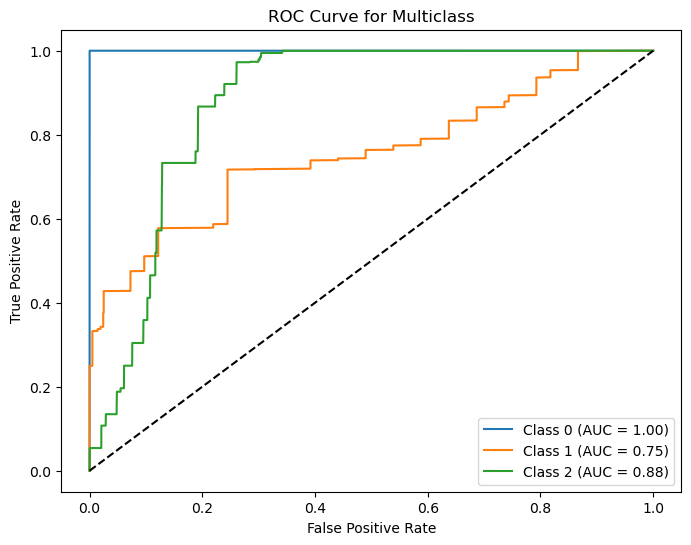

In [53]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_test.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass')
plt.legend(loc='best')
plt.show()

Confusion Matrix:
[[ 117861       0       0]
 [     51   16686   82038]
 [      0      71 1284220]]


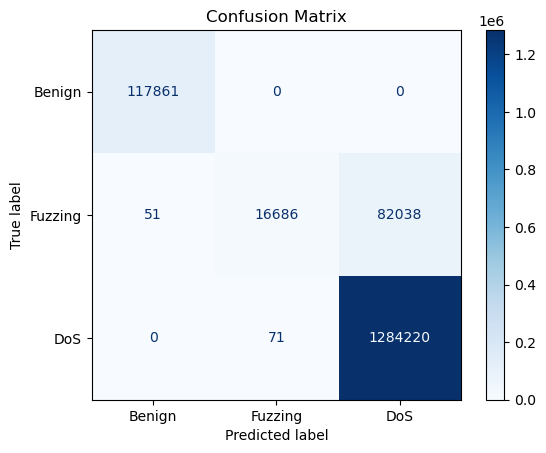

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
class_labels = ['Benign', 'Fuzzing', 'DoS']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


Class 0:
  False Positive Rate: 0.0000
  False Negative Rate: 0.0000
Class 1:
  False Positive Rate: 0.0003
  False Negative Rate: 0.0004
Class 2:
  False Positive Rate: 0.0000
  False Negative Rate: 0.0000
Confusion Matrix:
[[ 117861       0       0]
 [      0   98738      37]
 [      0      26 1284265]]


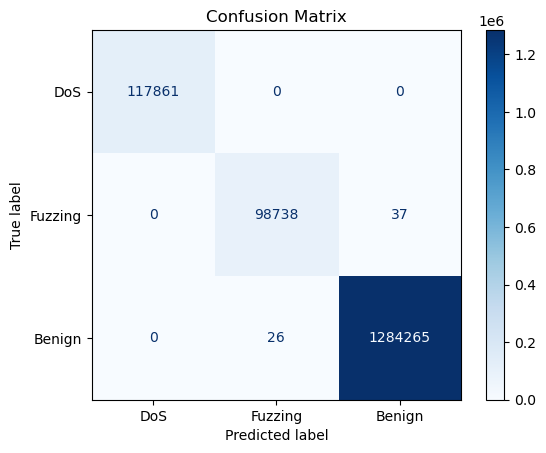

In [92]:
#correct classess assignments DoS = 0, Fuzzing = 1 and Benign = 2
for class_label in range(3):  # Loop through each class
    fp_rate, fn_rate = calculate_fp_fn_rates(y_test_classes, y_pred_classes, class_label)
    print(f"Class {class_label}:")
    print(f"  False Positive Rate: {fp_rate:.4f}")
    print(f"  False Negative Rate: {fn_rate:.4f}")

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
class_labels = ['DoS', 'Fuzzing', 'Benign']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# class weights
classes, class_counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)
class_weights = {cls: total_samples / (len(classes) * count) for cls, count in zip(classes, class_counts)}

# Print class weights (optional)
print("Class Weights:", class_weights)

Class Weights: {0.0: 0.25, 1.0: 0.5}


In [93]:
from sklearn.inspection import permutation_importance

In [ ]:
from tensorflow.keras.layers import ConvLSTM2D

model = Sequential()
model.add(ConvLSTM2D(filters=256, kernel_size=(3, 3), activation='sigmoid', input_shape=(None, X_train.shape[1], X_train.shape[2], 1), return_sequences=True))
model.add(ConvLSTM2D(filters=128, kernel_size=(3, 3), activation='sigmoid', return_sequences=True))
model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='sigmoid'))
model.add(Flatten())  # Flatten the output to feed into a dense layer
model.add(Dense(3, activation='softmax'))